In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Dice():
    def __init__(self, num_of_faces=6):
        self._n = np.random.uniform(0,1, num_of_faces)
        self._p = self._n/np.sum(self._n)
        self.faces = np.arange(num_of_faces)+1
        
    def sample(self, N):
        return np.random.choice(self.faces, N, p=self._p).tolist()

## 2-1. 変な形のサイコロ
既に何度か述べたように、機械学習の最終目的は **経験から未来を予想すること** です。
このことをいかにして表現すべきかの感覚を掴むために以下の例題を考えてみましょう。

この実装で、`num_of_faces`で指定した数の面を持ち、各面が出る確率も適当に初期化されたサイコロを作れます：

In [3]:
dice = Dice(num_of_faces=6)
X = dice.sample(N=10) # N回振る
X

[3, 3, 2, 1, 3, 5, 5, 5, 3, 4]

何回出たかは簡単に確認できます：

In [4]:
def count_faces(dice, X):
    return [X.count(i) for i in dice.faces]

count_faces(dice, X)

[1, 1, 4, 1, 3, 0]

沢山サイコロを振って、どの出目が何回出たかプロットしてみましょう：

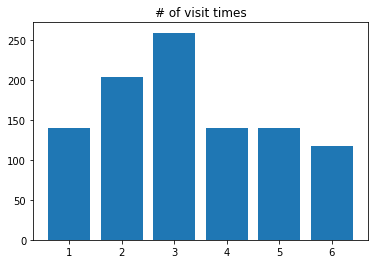

In [5]:
X = dice.sample(N=1000); num = count_faces(dice, X)
plt.title("# of visit times")
plt.bar(dice.faces, num); plt.show()

どうやらこのサイコロは均等な形をしておらず、各面が出る確率は**同じ確率では無い**ようです。唐突ですが、このサイコロを用いてギャンブルをしているとします。**このサイコロの各面 i が出る確率 $p_i$ がわかれば未来を予言できて有利でしょう**。上のような実際の出目だけから $p_i$ を推測するにはどうすればよいでしょうか？ここではより一般に

- $N$ 回サイコロを振り、1 が $N_1$ 回、2 が $N_2$ 回、...、6 が $N_6$ 回出た

とします。

### 最尤推定
一つの考え方は、確率を ''$q_i$'' と仮定して、実際のサンプルを得る確率を最大化することです。これを **最尤推定** といいます。実際に出た順番など気にしない場合、

$$
P = q_1^{N_1} q_2^{N_2} \cdots q_6^{N_6} \frac{N!}{N_1! N_2! \cdots N_6!}
$$

が「出目の確率を ''$q_i$'' と仮定したときに手持ちのサンプルがでてくる確率」となります。 $P$を最大化するのは$- \log P$を最小化するのと同じことなのでこちらを考えます。すると

$$
-\log P = -\sum_{i=1}^6 N_i \log q_i + (\text{constant})
$$

$q_i$ について最小化することになります。ただし$q_i$は確率なので規格化条件があることと、$N_i$ は合わせて $N$ でなくてはならないので、

$$
\sum_{i=1}^6 q_i = 1, \quad \sum_{i=1}^6 N_i = N
$$

の拘束条件を満たさねばなりません。この条件を考慮する便利な方法がラグランジュ未定乗数法です。解析の授業を思い出していただくと、$q_i$ について上の束縛条件を考える代わりに、新たな変数 $\lambda$ を導入し、ラグランジアン

$$
L(q_i, \lambda) = -\sum_{i=1}^6 N_i \log q_i + (\text{constant}) + \lambda \Big(\sum_{i=1}^6 q_i  - 1\Big)
$$

の停留点問題を解けばよいのでした。それぞれの微分値は

$$
\frac{\partial L}{\partial q_i} = - N_i \frac{1}{q_i} + \lambda, \quad \frac{\partial L}{\partial \lambda} = \sum_{i=1}^6 q_i - 1
$$

まず１つ目の微分値＝０から、

$$
0=- N_i \frac{1}{q_i} + \lambda \Rightarrow  q_i = \frac{N_i}{\lambda}
$$

次に２つ目の微分値＝０（$q_i$の規格化）から

$$
1 = \sum_{i=1}^6 q_i = \frac{1}{\lambda} \sum_{i=1}^6 N_i = \frac{N}{\lambda}
$$

となって、$\lambda = N$ を得ます。結局

$$
q_i = \frac{N_i}{N}
$$

となり、出目の実際の割合にしておくのが良さそうだという結果を得ます。サンプル数（試行回数）$N$ を増やすと精度が上がると期待されますが、実際、大数の法則により $N$ を十分大きく取れば$\frac{N_i}{N} \approx p_i$となることが示せます。

#### 実験
実は `dice._p` で真の確率 $p_i$ を見ることができるようにしてあります：

In [6]:
dice._p

array([0.13346283, 0.19876804, 0.27750835, 0.12640069, 0.13609152,
       0.12776856])

上で導出した推定値 $q_i$ の公式を $N$ 毎に計算するのも簡単にできます：

In [7]:
def return_q(N):
    X = dice.sample(N)
    q = [X.count(i)/N for i in dice.faces]
    return q

これはどれくらい真の値に近いでしょうか？$N$ 大でやってみると

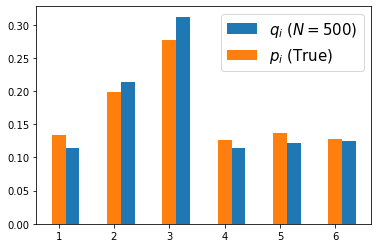

In [10]:
N = 500
plt.bar(dice.faces+1/4, return_q(N), width=1/4, label=r'$q_i$ ($N={}$)'.format(N))
plt.bar(dice.faces, dice._p, width=1/4, label=r'$p_i$ (True)')
plt.legend(fontsize=15); plt.show()

で、似ていないでもないですが、定量的に**どれくらい真の値からずれているか** 知りたい気もします。つまり、
- $p_i$ と $q_i$ の差を測るもの＝**距離**はあるか？

というのが次の問です。

### KL情報量
その**距離**はこの小節で考えてきたサイコロの問題の**最尤推定**にて $N \to \infty$ を考えると自然に得られます。一旦モデルを$q_i$としたときのデータの実現確率まで戻ってみましょう。

$$
P = q_1^{N_1} q_2^{N_2} \cdots q_6^{N_6}
\frac{N!}{N_1! N_2! \cdots N_6!}
$$

大数の法則を適用できるくらい $N$ が大きいとすると、

$$
N_i \approx p_i N
$$

です。更に $N$ が大きいので、スターリングの公式をもちいて

$$
N! \approx N^{N},
\quad
N_i ! \approx N_i^{N_i}
$$

とすると
>スターリングの公式の一番大きな寄与だけ取り出して簡略化しています。

$$
\left. \begin{array}{ll}
P
&\approx
q_1^{N_1} q_2^{N_2} \cdots q_6^{N_6} \frac{N^N}{N_1^{N_1} N_2^{N_2} \cdots N_6^{N_6}}
\\
&\approx %%%%
q_1^{N_1} q_2^{N_2} \cdots q_6^{N_6} \frac{N^N}{(p_1 N)^{N_1} (p_2 N)^{N_2} \cdots (p_6 N)^{N_6}}
\\
&= %%%%
\Big( \frac{q_1}{p_1} \Big)^{N_1} \Big( \frac{q_2}{p_2} \Big)^{N_2} \cdots \Big( \frac{q_6}{p_6} \Big)^{N_6} \frac{N^N}{N^{N_1 + N_2 + \cdots N_6}}
\\
&= %%%%
e^{-\sum_{i=1}^6 N_i \log \frac{p_i}{q_i}}
\approx
e^{- N \sum_{i=1}^6 p_i \log \frac{p_i}{q_i}}
\end{array} \right.
$$

ですが、これは

$$
\text{Larger }P\Leftrightarrow\text{Smaller }\sum_{i=1}^6 p_i \log \frac{p_i}{q_i} =: D_{KL}(p\mid\mid q)
$$

とも言えます。より一般に、連続変数でも

$$
D_{KL}(p\mid\mid q) := \int p({\bf x}) \log \frac{p({\bf x})}{q({\bf x})} d {\bf x}
$$

とし、これを**KL情報量**といいます。

In [8]:
def KL(p, q, epsilon=1e-10):
    ''' qにゼロがある場合に備えepsilonでオーバーフロー対策 '''
    p_np = np.array(p)
    q_np = np.array(q)
    return np.sum(p_np*np.log((p_np+epsilon)/(q_np+epsilon)))

これを使えば、$q_i^{(N)} = \frac{N_i}{N}$ がどれくらい真の $p_i$ を良く近似しているかわかります。

In [9]:
p = dice._p
q = return_q(10)
KL(p, q), KL(p, p)

(4.167127002623975, 0.0)

実際 $N$ 横軸に $D_{KL}(p\mid\mid q^{(N)})$ をプロットしてみると、

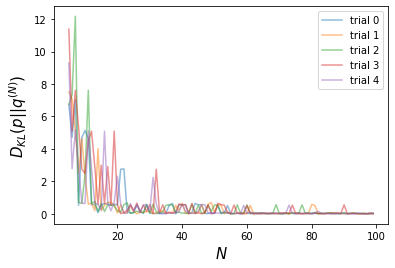

In [10]:
Ns = np.arange(5, 100)
plt.xlabel(r'$N$', fontsize=15); plt.ylabel(r'$D_{KL}(p\|\|q^{(N)})$', fontsize=15)
for trial in range(5):
    plt.plot(Ns, [KL(p, return_q(N)) for N in Ns], '-', alpha=0.5, label='trial {}'.format(trial))
plt.legend(); plt.show()

たしかに $N \to \infty$ で0に近づいてゆくのがわかります。